In [ ]:
# Only use this code block if you are using Google Colab.
# If you are using Jupyter Notebook, please ignore this code block. You can directly upload the file to your Jupyter Notebook file systems.
from google.colab import files

## It will prompt you to select a local file. Click on “Choose Files” then select and upload the file. 
## Wait for the file to be 100% uploaded. You should see the name of the file once Colab has uploaded it.
uploaded = files.upload()

Saving df_completeMy_en.pkl to df_completeMy_en.pkl


#1.Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

import seaborn as sns
from sklearn.model_selection import train_test_split
from itertools import product
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
!pip install category_encoders
import category_encoders as ce
import warnings
import datetime 

from wordcloud import WordCloud
from wordcloud import STOPWORDS
import time

     |████████████████████████████████| 82 kB 359 kB/s 


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


##Basic data processing

### Read the dataset

In [ ]:
categories = pd.read_csv('categories.csv')
items = pd.read_csv('items_en.csv', encoding="ISO-8859-1")
shops = pd.read_csv('shops_en.csv')
sales_train = pd.read_csv('sales_train.csv')
test = pd.read_csv('test.csv')

### downcast

Save memory

In [ ]:
def downcast_dtypes(df):
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols = [c for c in df if df[c].dtype in ["int64", "int32"]]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    return df

categories = downcast_dtypes(categories)
items = downcast_dtypes(items)
shops = downcast_dtypes(shops)
sales_train = downcast_dtypes(sales_train)
test=downcast_dtypes(test)

In [ ]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.000000,1.0
1,03.01.2013,0,25,2552,899.000000,1.0
2,05.01.2013,0,25,2552,899.000000,-1.0
3,06.01.2013,0,25,2554,1709.050049,1.0
4,15.01.2013,0,25,2555,1099.000000,1.0


In [ ]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


training set, 21,807 items, 60 stores. A total of 2,935,849 item-store combinations.

Test set, 5,100 items, 42 stores. That's exactly 5100 * 42 = 214,200 items-store combinations.

In [ ]:
print('how many lines in train set:', sales_train.shape)
print('unique items in train set:', sales_train['item_id'].nunique())
print('unique shops in train set:', sales_train['shop_id'].nunique())
print('how many lines in test set:', test.shape)
print('unique items in test set:', test['item_id'].nunique())
print('unique shops in test set:', test['shop_id'].nunique())


how many lines in train set: (2935849, 6)
unique items in train set: 21807
unique shops in train set: 60
how many lines in test set: (214200, 3)
unique items in test set: 5100
unique shops in test set: 42


In [ ]:
sales_train.isnull().sum()  #没有缺失值

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [ ]:
sales_train.isna().sum()   #没有nan

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

###Baseline model prediction

First try to reproduce the baseline model. In this project, the baseline model takes the sales of the 34th month as the sales of the 35th month, and the result of October 2015 as the forecast of November 2015.

The data in the training set are item-store-daily sales. The forecast is for the item-store-monthly sales, so the groupby() and agg() functions need to be used properly.

For the combination of commodity and store that does not appear in the training set, fill in zero, and the final result needs to be in the range of [0,20].

In [ ]:
sales_train_subset = sales_train[sales_train['date_block_num'] == 33]
sales_train_subset.head()

grouped = sales_train_subset[['shop_id','item_id','item_cnt_day']].groupby(['shop_id','item_id']).agg({'item_cnt_day':'sum'}).reset_index()
grouped = grouped.rename(columns={'item_cnt_day' : 'item_cnt_month'})
grouped.head()


,shop_id,item_id,item_cnt_month
0,2,31,1.0
1,2,486,3.0
2,2,787,1.0
3,2,794,1.0
4,2,968,1.0


In [ ]:
test = pd.merge(test,grouped, on = ['shop_id','item_id'], how = 'left')
print(test.head())

   ID  shop_id  item_id  item_cnt_month
0   0        5     5037             NaN
1   1        5     5320             NaN
2   2        5     5233             1.0
3   3        5     5232             NaN
4   4        5     5268             NaN


In [ ]:
test['item_cnt_month'] = test['item_cnt_month'].fillna(0).clip(0,20)
print(test.head())
test = test[['ID','item_cnt_month']]
submission = test.set_index('ID')
submission.to_csv('submission_baseline.csv')

   ID  shop_id  item_id  item_cnt_month
0   0        5     5037             0.0
1   1        5     5320             0.0
2   2        5     5233             1.0
3   3        5     5232             0.0
4   4        5     5268             0.0


#2.Exploratory Data Analysis and Data Preprocessing




##The analysis of training set sales_train

We used Pivot_table to see monthly sales for each item. Pivot_table () and groupby() serve similar purposes, but are more flexible and can do more with columns.

In [ ]:
sales_by_item_id = sales_train.pivot_table(index=['item_id'],values=['item_cnt_day'], 
                                        columns='date_block_num', aggfunc=np.sum, fill_value=0).reset_index()
sales_by_item_id.columns = sales_by_item_id.columns.droplevel().map(str)
sales_by_item_id = sales_by_item_id.reset_index(drop=True).rename_axis(None, axis=1)
sales_by_item_id.columns.values[0] = 'item_id'

In [ ]:
sales_by_item_id.tail()

,item_id,0,1,2,3,4,5,6,7,8,...,24,25,26,27,28,29,30,31,32,33
21802,22165,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
21803,22166,0,0,0,0,0,0,0,0,0,...,7,8,12,4,8,10,8,11,5,11
21804,22167,0,0,0,0,0,0,0,0,56,...,33,46,40,38,31,33,34,29,21,37
21805,22168,2,2,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
21806,22169,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:>

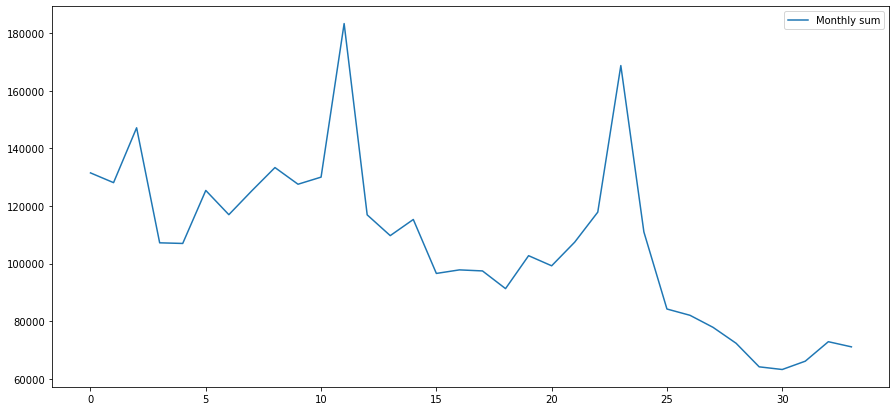

In [ ]:
sales_by_item_id.sum()[1:].plot(legend=True, label="Monthly sum")


We can get that the sales is decreasing. But it reach the peak in November

In [ ]:
train = sales_train.join(items, on='item_id', rsuffix='_').join(shops, on='shop_id', rsuffix='_').join(categories, on='category_id', rsuffix='_').drop(['item_id_', 'shop_id_', 'category_id_'], axis=1)

In [ ]:
train_vis = train.copy()
train_vis['sales'] = train_vis['item_price'] * train_vis['item_cnt_day']

In [ ]:
train_dataset=sales_train.copy()    

<BarContainer object of 60 artists>

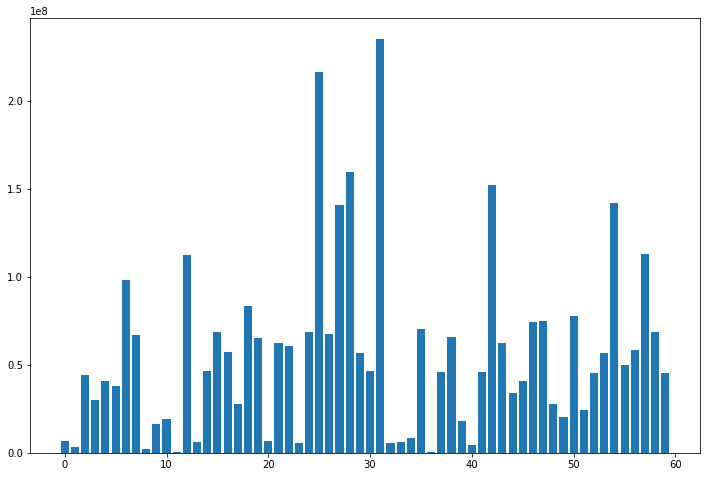

In [ ]:
# barplot: total sales of each shop
# 销售额-shop_id 柱状图

shop_sales = pd.DataFrame(train_vis.groupby(by=['shop_id'])['sales'].sum())
shop_sales.reset_index()
plt.figure(figsize=(12,8))
plt.bar(shop_sales.index, shop_sales['sales'])

<BarContainer object of 60 artists>

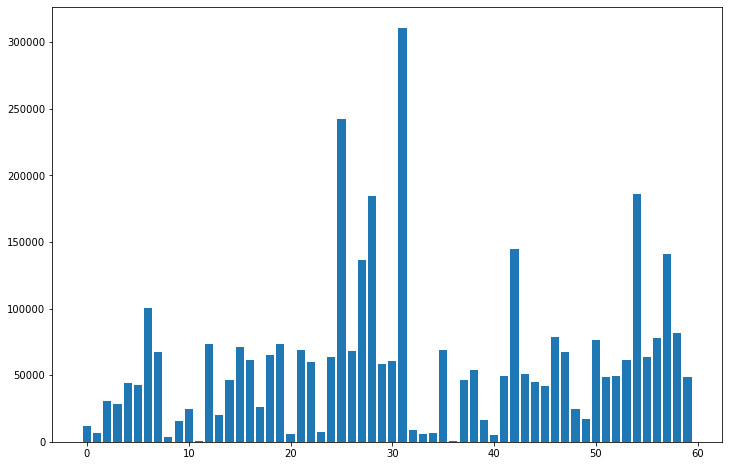

In [ ]:
# barplot: total item_cnt of each shop
# 销售数量-shop_id 柱状图

shop_sales = pd.DataFrame(train_vis.groupby(by=['shop_id'])['item_cnt_day'].sum())
shop_sales.reset_index()
plt.figure(figsize=(12,8))
plt.bar(shop_sales.index, shop_sales['item_cnt_day'])

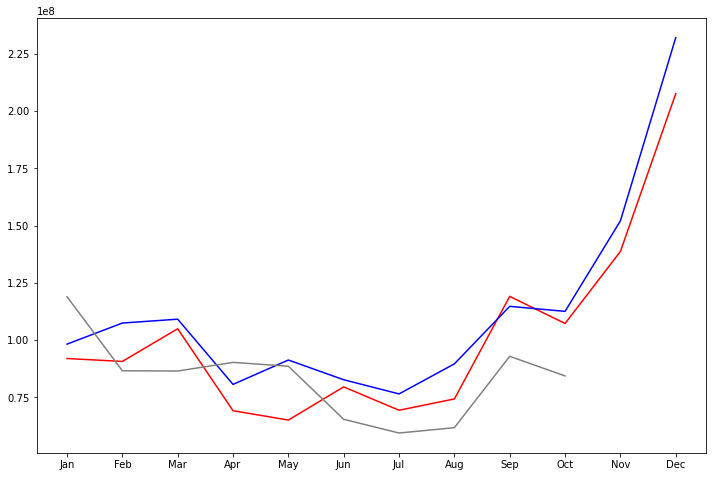

In [ ]:
# 月份-销售额 折线图

MONTHS = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_sales = pd.DataFrame(train_vis.groupby(by=['date_block_num'])['sales'].sum())
monthly_sales.reset_index()
monthly_sales_2013 = monthly_sales[0:12]
monthly_sales_2014 = monthly_sales[12:24]
monthly_sales_2015 = monthly_sales[24:34]

plt.figure(figsize=(12,8))
plt.plot(MONTHS, monthly_sales_2013['sales'], color='red')
plt.plot(MONTHS, monthly_sales_2014['sales'], color='blue')
plt.plot(MONTHS[:10], monthly_sales_2015['sales'], color='grey')

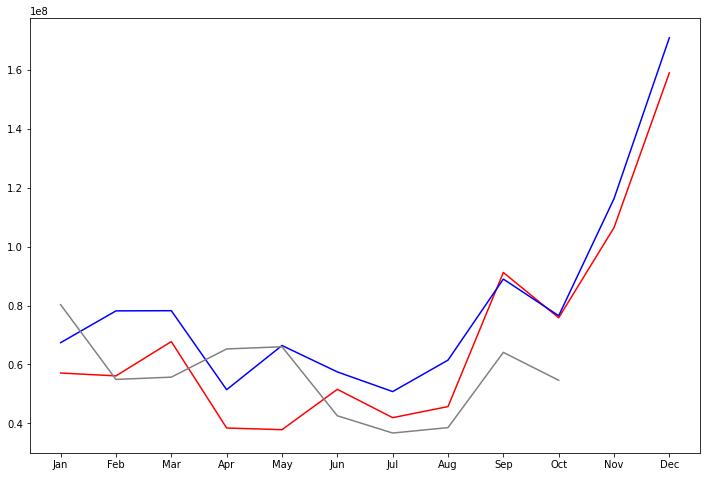

In [ ]:
# 将categoryid 0-31 设为游戏
# 游戏销售额-月份 折线图

game_sales = train_vis.loc[train_vis['category_id'] <= 31]
game_monthly_sales = pd.DataFrame(game_sales.groupby(by=['date_block_num'])['sales'].sum())

game_monthly_sales.reset_index()
game_monthly_sales_2013 = game_monthly_sales[0:12]
game_monthly_sales_2014 = game_monthly_sales[12:24]
game_monthly_sales_2015 = game_monthly_sales[24:34]

plt.figure(figsize=(12,8))
plt.plot(MONTHS, game_monthly_sales_2013['sales'], color='red')
plt.plot(MONTHS, game_monthly_sales_2014['sales'], color='blue')
plt.plot(MONTHS[:10], game_monthly_sales_2015['sales'], color='grey')

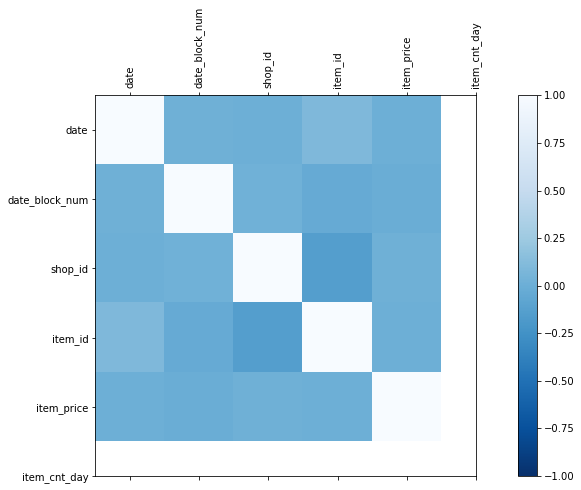

In [ ]:
####Check correlation
corr = train_dataset.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='Blues_r', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(train_dataset.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(train_dataset.columns)
ax.set_yticklabels(train_dataset.columns)
plt.show()
####There are no noticeably strong pos/neg correlation in sight

D:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


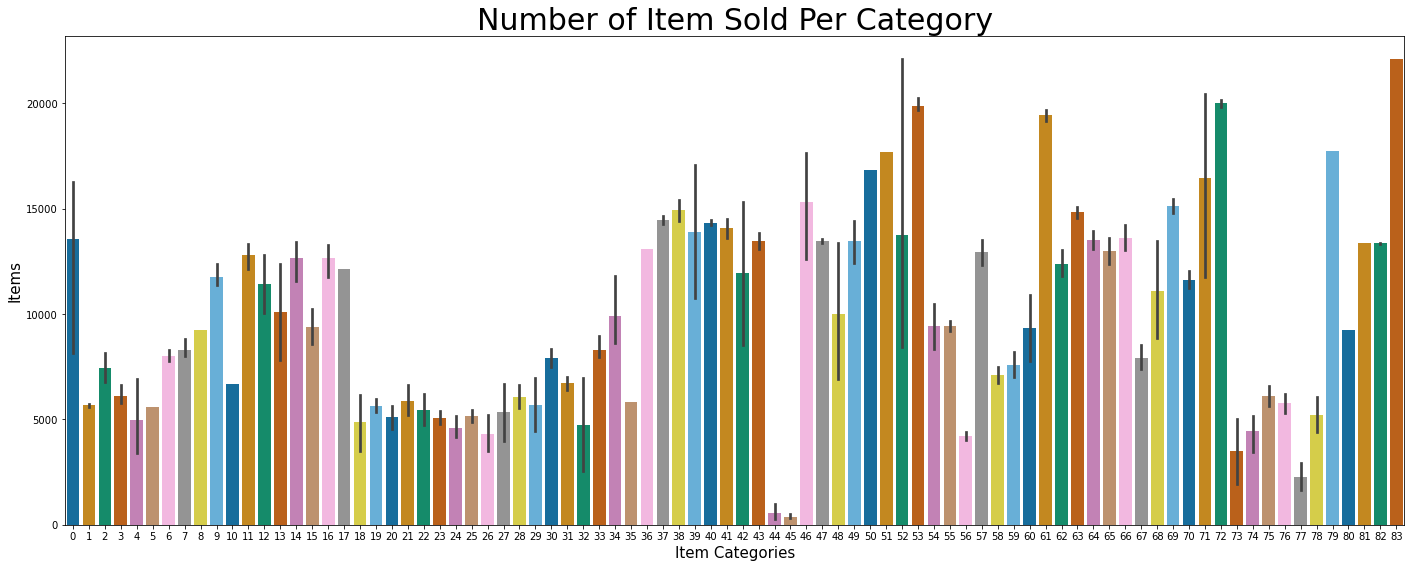

In [ ]:
######Checking how many items sold per category
plt.rcParams['figure.figsize'] = (24, 9)
sns.barplot(items['category_id'], items['item_id'], palette = 'colorblind')
plt.title('Number of Item Sold Per Category', fontsize = 30)
plt.xlabel('Item Categories', fontsize = 15)
plt.ylabel('Items', fontsize = 15)
plt.show()

D:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


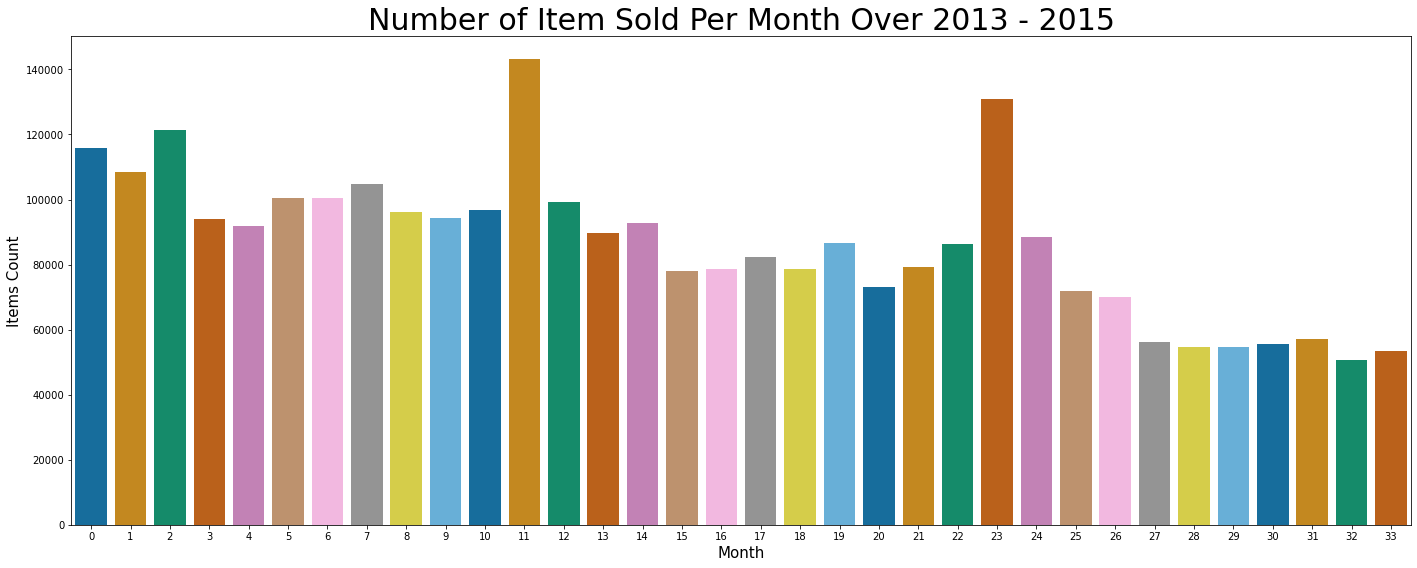

In [ ]:
#####Checking how many items sold per per month i.e. (jan 2013 ~ Oct 2015)
plt.rcParams['figure.figsize'] = (24, 9)
sns.countplot(train_dataset['date_block_num'], palette = 'colorblind')
plt.title('Number of Item Sold Per Month Over 2013 - 2015', fontsize = 30)
plt.xlabel('Month', fontsize = 15)
plt.ylabel('Items Count', fontsize = 15)
plt.show()

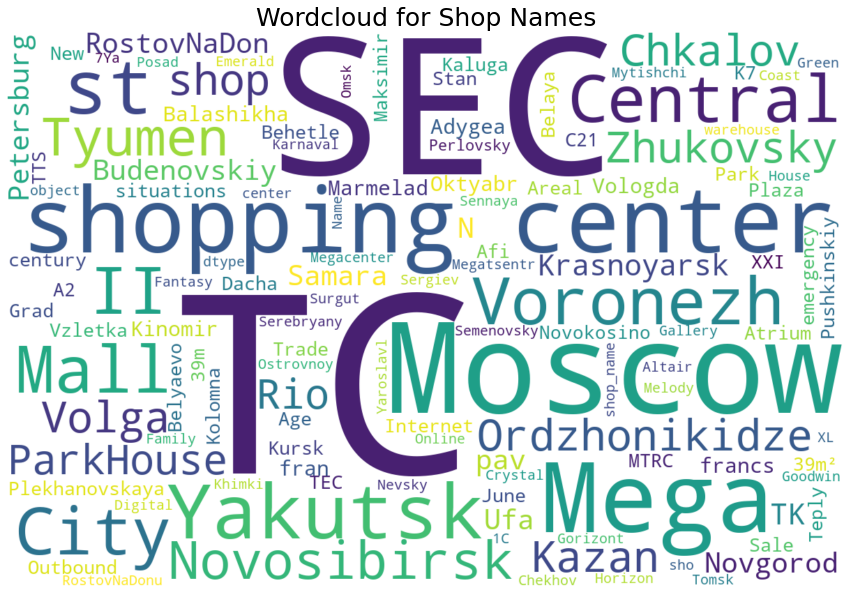

In [ ]:
# WordCloud for shop name
plt.rcParams['figure.figsize'] = (15, 12)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(background_color = 'white',
                      max_words = 200, 
                      stopwords = stopwords,
                     width = 1200,
                     height = 800,
                     random_state = 42).generate(str(shops['shop_name']))


plt.title('Wordcloud for Shop Names', fontsize = 25)
plt.axis('off')
plt.imshow(wordcloud, interpolation = 'bilinear')

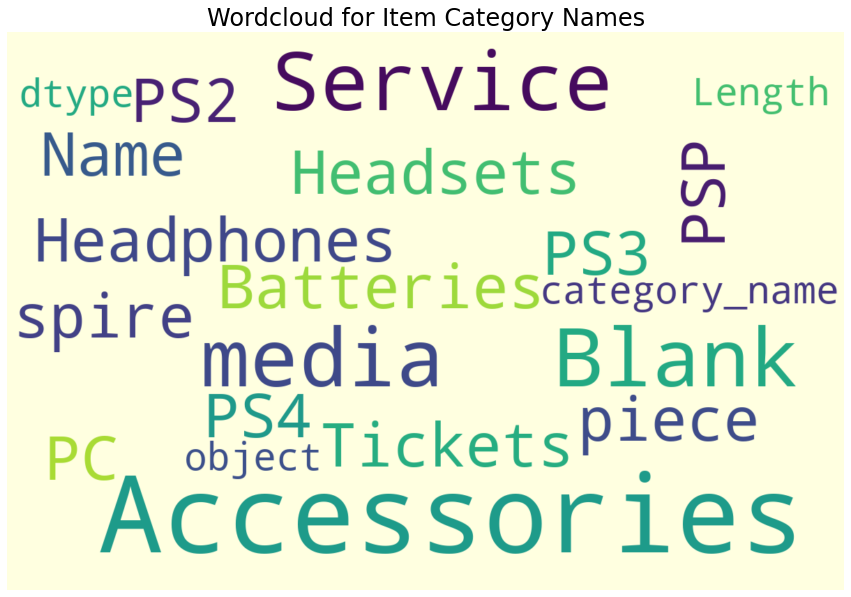

In [ ]:
# wordcloud for item categories
plt.rcParams['figure.figsize'] = (15, 12)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(background_color = 'lightyellow',
                      max_words = 200, 
                      stopwords = stopwords,
                     width = 1200,
                     height = 800,
                     random_state = 42).generate(str(categories['category_name']))


plt.title('Wordcloud for Item Category Names', fontsize = 24)
plt.axis('off')
plt.imshow(wordcloud, interpolation = 'bilinear')

In [ ]:
#####Busiest days for the shop
###  converting the date into datetimelike format
###  i.e. 01.02.2013 ==> 2013-02-01

train_dataset['date'] = pd.to_datetime(train_dataset['date'], errors='coerce')

In [ ]:
days = []
months = []
years = []

for day in train_dataset['date']:
    days.append(day.day)
for month in train_dataset['date']:
    months.append(month.month)    
for year in train_dataset['date']:
    years.append(year.year)

D:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


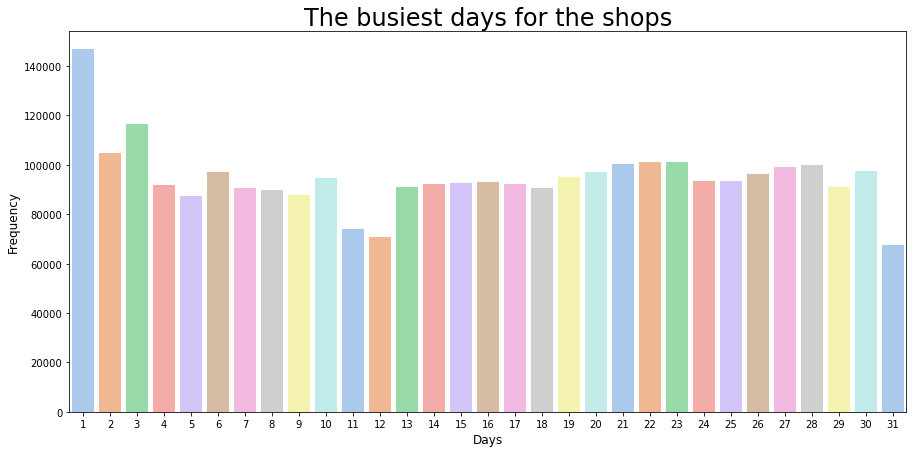

In [ ]:
plt.rcParams['figure.figsize'] = (15, 7)
sns.countplot(days, palette= 'pastel')
plt.title('The busiest days for the shops', fontsize = 24)
plt.xlabel('Days', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)

plt.show()

D:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


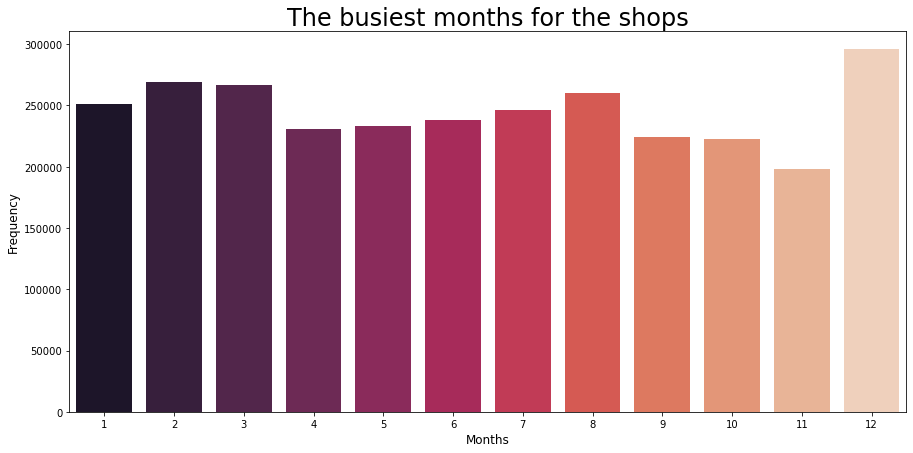

D:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


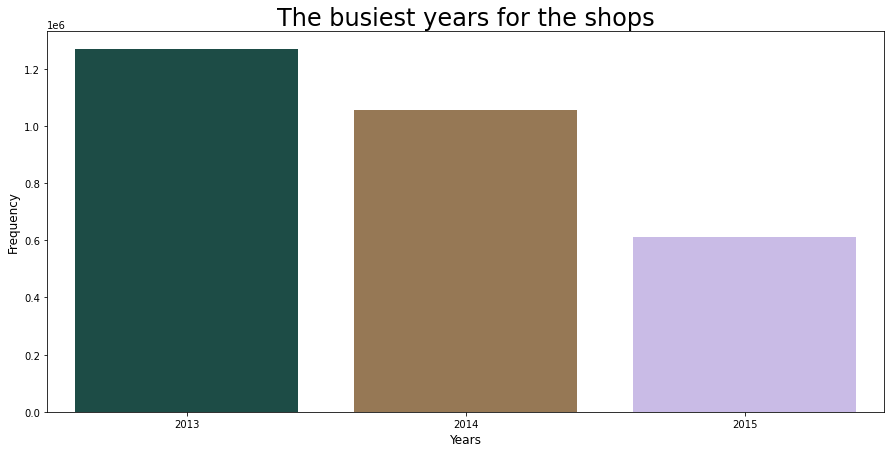

In [ ]:
###Busiest months and years for shops
# busy month
plt.rcParams['figure.figsize'] = (15, 7)
sns.countplot(months, palette= 'rocket')
plt.title('The busiest months for the shops', fontsize = 24)
plt.xlabel('Months', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)

plt.show()

# busy year
plt.rcParams['figure.figsize'] = (15, 7)
sns.countplot(years, palette= 'cubehelix')
plt.title('The busiest years for the shops', fontsize = 24)
plt.xlabel('Years', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)

plt.show()

In [ ]:
train_dataset['day'] = days
train_dataset['month'] = months
train_dataset['year'] = years
train_dataset

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,day,month,year
0,2013-02-01,0,59,22154,999.000000,1.0,1,2,2013
1,2013-03-01,0,25,2552,899.000000,1.0,1,3,2013
2,2013-05-01,0,25,2552,899.000000,-1.0,1,5,2013
3,2013-06-01,0,25,2554,1709.050049,1.0,1,6,2013
4,2013-01-15,0,25,2555,1099.000000,1.0,15,1,2013
...,...,...,...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.000000,1.0,10,10,2015
2935845,2015-09-10,33,25,7460,299.000000,1.0,10,9,2015
2935846,2015-10-14,33,25,7459,349.000000,1.0,14,10,2015
2935847,2015-10-22,33,25,7440,299.000000,1.0,22,10,2015


Analyze how many items have not been sold in the last six consecutive months. How many of these items appear in the test set.

The training set has a total of 21,807 items, of which 12,391 have not been sold in the last six months.

There are 5100 items in the test set, 164 of which have not sold in the last six months of training, showing up 164 * 42 = 6888 times.

Tips: In the final prediction, we can set sales of these items at zero.

In [ ]:

outdated_items = sales_by_item_id[sales_by_item_id.loc[:,'27':].sum(axis=1)==0]
print('Outdated items:', len(outdated_items))
test = pd.read_csv('test.csv')
print('unique items in test set:', test['item_id'].nunique())
print('Outdated items in test set:', test[test['item_id'].isin(outdated_items['item_id'])]['item_id'].nunique())


Outdated items: 12391
unique items in test set: 5100
Outdated items in test set: 164


There are 6 lines in the training set, which are repeated

In [ ]:
print("duplicated lines in sales_train is", len(sales_train[sales_train.duplicated()]))  


duplicated lines in sales_train is 6


###Sales per store

There are 60 stores in total, located in 31 cities, and the city information can be a feature of the store.

So let's take a look at which stores were recently opened and which were closed, as well as the last six months.

shop_id = 36 is a new store

shop_id = [0 1 8 11 13 17 23 29 30 32 33 40 43 54] are the stores that closed

Tips：The new store can directly use the 33rd month to predict the 34th month's sales because it doesn't have any historical data. For closed stores, sales can be set to zero


In [ ]:
sales_by_shop_id = sales_train.pivot_table(index=['shop_id'],values=['item_cnt_day'], 
                                        columns='date_block_num', aggfunc=np.sum, fill_value=0).reset_index()
sales_by_shop_id.columns = sales_by_shop_id.columns.droplevel().map(str)
sales_by_shop_id = sales_by_shop_id.reset_index(drop=True).rename_axis(None, axis=1)
sales_by_shop_id.columns.values[0] = 'shop_id'

for i in range(27,34):
    print('Not exists in month',i,sales_by_shop_id['shop_id'][sales_by_shop_id.loc[:,'0':str(i)].sum(axis=1)==0].unique())

for i in range(27,34):
    print('Shop is outdated for month',i,sales_by_shop_id['shop_id'][sales_by_shop_id.loc[:,str(i):].sum(axis=1)==0].unique())


Not exists in month 27 [36]
Not exists in month 28 [36]
Not exists in month 29 [36]
Not exists in month 30 [36]
Not exists in month 31 [36]
Not exists in month 32 [36]
Not exists in month 33 []
Shop is outdated for month 27 [ 0  1  8 11 13 17 23 30 32 40 43]
Shop is outdated for month 28 [ 0  1  8 11 13 17 23 30 32 33 40 43 54]
Shop is outdated for month 29 [ 0  1  8 11 13 17 23 29 30 32 33 40 43 54]
Shop is outdated for month 30 [ 0  1  8 11 13 17 23 29 30 32 33 40 43 54]
Shop is outdated for month 31 [ 0  1  8 11 13 17 23 29 30 32 33 40 43 54]
Shop is outdated for month 32 [ 0  1  8 11 13 17 23 29 30 32 33 40 43 54]
Shop is outdated for month 33 [ 0  1  8 11 13 17 23 27 29 30 32 33 40 43 51 54]


###Sales per category

In order to use the category of the item, you need to read the information for Item_categories and add it to sales_train

In [ ]:
items.head()

,item_id,category_id,item_name
0,0,40,!! IN THE POWER OF HAPPINESS (PLAST) D
1,1,76,! ABBYY FineReader 12 Professional Edition Ful...
2,2,40,*** IN THE GLORY OF THE GLORY (UNV) D
3,3,40,*** BLUE WAVE (Univ) D
4,4,40,*** BOX (GLASS) D


In [ ]:
#clean item_name
items['item_name'] = items['item_name'].str.lower()
items['item_name'] = items['item_name'].str.replace('.', '')
for i in [r'[^\w\d\s\.]', r'\bthe\b', r'\bin\b', r'\bis\b',
          r'\bfor\b', r'\bof\b', r'\bon\b', r'\band\b',  
          r'\bto\b', r'\bwith\b' , r'\byo\b']:
    items['item_name'] = items['item_name'].str.replace(i, ' ')
items['item_name'] = items['item_name'].str.replace(r'\b.\b', ' ')
items.head()

<ipython-input-294-2e323498a30c>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  items['item_name'] = items['item_name'].str.replace('.', '')
<ipython-input-294-2e323498a30c>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  items['item_name'] = items['item_name'].str.replace(i, ' ')
<ipython-input-294-2e323498a30c>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  items['item_name'] = items['item_name'].str.replace(r'\b.\b', ' ')


,item_id,category_id,item_name
0,0,40,power happiness plast
1,1,76,abbyy finereader 12 professional edition ful...
2,2,40,glory glory unv
3,3,40,blue wave univ
4,4,40,box glass


In [ ]:
# Duplicate rows exist in the item list. 
# The following cell creates a dictionary that will allow us to reassign item id's where appropriate.

In [ ]:
dupes = items[(items.duplicated(subset=['item_name','category_id'],keep=False))]
dupes['in_test'] = dupes.item_id.isin(test.item_id.unique())
dupes = dupes.groupby('item_name').agg({'item_id':['first','last'],'in_test':['first','last']})

#if both item id's are in the test set do nothing
dupes = dupes[(dupes[('in_test', 'first')]==False) | (dupes[('in_test', 'last')]==False)]
#if only the first id is in the test set assign this id to both
temp = dupes[dupes[('in_test', 'first')]==True]
keep_first = dict(zip(temp[('item_id', 'last')], temp[('item_id',  'first')]))
#if neither id or only the second id is in the test set, assign the second id to both
temp = dupes[dupes[('in_test', 'first')]==False]
keep_second = dict(zip(temp[('item_id', 'first')], temp[('item_id',  'last')]))
item_map = {**keep_first, **keep_second}
dupes

<ipython-input-296-77daa6dd8da9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dupes['in_test'] = dupes.item_id.isin(test.item_id.unique())


item_id        in_test       
                                            first   last   first   last
item_name                                                              
                                               32  10725    True  False
      art   electro swing     digipack       7453   7454   False  False
      best   lounge     4cd  digibook        7456   7457   False  False
      instrumental hits best                 7516   7517   False  False
      love vocal house     2cd  digipack     7368   7369   False  False
...                                           ...    ...     ...    ...
wrc    pc  digital version                   7716   7717   False   True
yellow                                       8075   8077   False   True
yellow    bd                                 8076   8078   False   True
yesterday   war was finished    region      10117  10118   False  False
zykina lyudmila russian folk songs          11809  11810   False  False

[453 rows x 4 columns]

In [ ]:
#item_categories = pd.read_csv('items_en.csv')
item_categories=items
item_categories = item_categories[['item_id','category_id']]

In [ ]:
item_categories.head()

,item_id,category_id
0,0,40
1,1,76
2,2,40
3,3,40
4,4,40


In [ ]:
sales_train_merge_cat = pd.merge(sales_train,item_categories, on = 'item_id', how = 'left')
sales_train_merge_cat.head()


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,category_id
0,02.01.2013,0,59,22154,999.000000,1.0,37
1,03.01.2013,0,25,2552,899.000000,1.0,58
2,05.01.2013,0,25,2552,899.000000,-1.0,58
3,06.01.2013,0,25,2554,1709.050049,1.0,58
4,15.01.2013,0,25,2555,1099.000000,1.0,56


###Outliers of sales and price

Find the outliers for sales and price from sales_train and process them.

Sale volume outliers: [2169.]
Sale price outliers: [307980.]


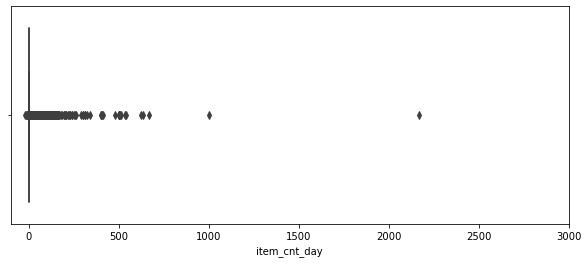

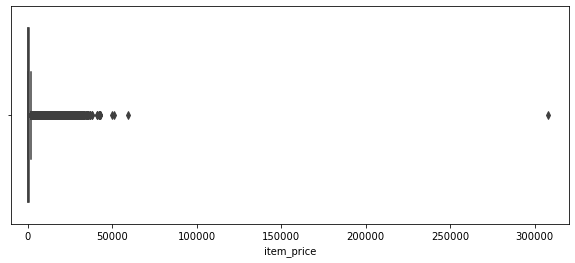

In [ ]:
plt.figure(figsize=(10,4))
plt.xlim(-100,3000)
sns.boxplot(x = sales_train['item_cnt_day'])
print('Sale volume outliers:',sales_train['item_cnt_day'][sales_train['item_cnt_day']>1000].unique())
plt.figure(figsize=(10,4))
plt.xlim(-10000,320000)
sns.boxplot(x = sales_train['item_price'])
print('Sale price outliers:',sales_train['item_price'][sales_train['item_price']>300000].unique())


In [ ]:
# ###去除outliers。 
# sales2=sales_train.copy()
# sales2 = sales2[(sales2["item_price"] > 0) & (sales2["item_price"] < 50000)]
# #train_dataset2 = train_dataset2[(train_dataset2["item_cnt_day"] > 0) & (train_dataset2["item_cnt_day"] < 1000)]   ###1001?

<AxesSubplot:xlabel='item_price'>

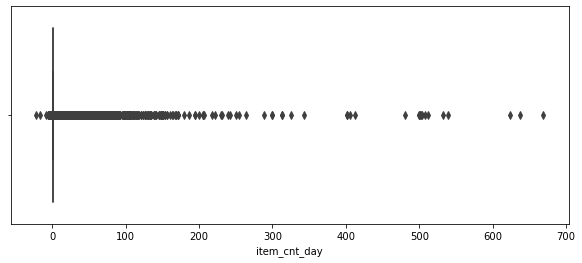

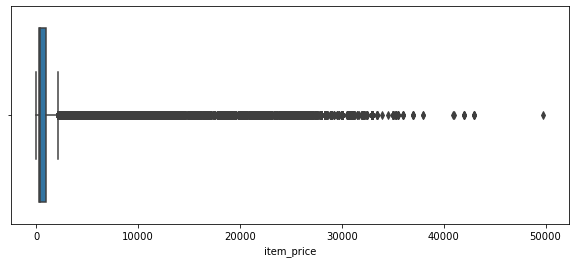

In [ ]:
sales_train = sales_train[sales_train['item_cnt_day'] <1000]
sales_train = sales_train[sales_train['item_price'] < 50000]
plt.figure(figsize=(10,4))
#plt.xlim(-100,3000)
sns.boxplot(x = sales_train['item_cnt_day'])

plt.figure(figsize=(10,4))
#plt.xlim(-10000,320000)
sns.boxplot(x = sales_train['item_price'])

In [ ]:
 # 有一个商品的价格是负值，将其填充为median。
sales_train[sales_train['item_price']<0] 


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


In [ ]:
median = sales_train[(sales_train['date_block_num'] == 4) & (sales_train['shop_id'] == 32)\
                     & (sales_train['item_id'] == 2973) & (sales_train['item_price']>0)].item_price.median()
sales_train.loc[sales_train['item_price']<0,'item_price'] = median
print(median)


1874.0


In [ ]:
#####item卖出去的数量也有<0的
sales_train[train_dataset['item_cnt_day'] < 0]
###item_cnt_day < 0 or -1 probably means that those items were returned. 
###If the Items are returned then there are no sales involved as well. So, we can get rid of negative values and set it as 0.

<ipython-input-305-fead3b9f4c9d>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sales_train[train_dataset['item_cnt_day'] < 0]


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2,05.01.2013,0,25,2552,899.0,-1.0
148,23.01.2013,0,25,2321,999.0,-1.0
175,07.01.2013,0,25,2199,1449.0,-1.0
807,02.01.2013,0,25,2330,599.0,-1.0
1041,13.01.2013,0,25,5034,1989.0,-1.0
...,...,...,...,...,...,...
2934243,26.10.2015,33,25,3917,449.0,-1.0
2934462,18.10.2015,33,25,4896,6398.0,-1.0
2935263,05.10.2015,33,25,10039,249.0,-1.0
2935643,16.10.2015,33,25,7893,2990.0,-1.0


In [ ]:
sales_train["item_cnt_day"] = train_dataset["item_cnt_day"].map(lambda x: 0 if x<0 else x)

In [ ]:
sales_train[train_dataset['item_cnt_day'] < 0]

<ipython-input-307-436c4e68bcaf>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sales_train[train_dataset['item_cnt_day'] < 0]


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2,05.01.2013,0,25,2552,899.0,0.0
148,23.01.2013,0,25,2321,999.0,0.0
175,07.01.2013,0,25,2199,1449.0,0.0
807,02.01.2013,0,25,2330,599.0,0.0
1041,13.01.2013,0,25,5034,1989.0,0.0
...,...,...,...,...,...,...
2934243,26.10.2015,33,25,3917,449.0,0.0
2934462,18.10.2015,33,25,4896,6398.0,0.0
2935263,05.10.2015,33,25,10039,249.0,0.0
2935643,16.10.2015,33,25,7893,2990.0,0.0


##The analysis of test dataset

The test set has 5,100 items and 42 stores. That's exactly 5100 * 42 = 214,200 items-store combinations. It can be divided into three broad categories:

363 items did not appear in the training set, 363*42=15,246 items – store combinations had no data, accounting for about 7%.

87,550 items - Store combinations are items that only appear, not combinations. Accounted for about 42%

111,404 item - store combinations are all present in the training set. Accounts for about 51%.


In [ ]:
#test = pd.read_csv('test.csv')
test=test
good_sales = test.merge(sales_train, on=['item_id','shop_id'], how='left').dropna()
good_pairs = test[test['ID'].isin(good_sales['ID'])]
no_data_items = test[~(test['item_id'].isin(sales_train['item_id']))]

print('1. Number of good pairs:', len(good_pairs))
print('2. No Data Items:', len(no_data_items))
print('3. Only Item_id Info:', len(test)-len(no_data_items)-len(good_pairs))


1. Number of good pairs: 111404
2. No Data Items: 15246
3. Only Item_id Info: 87550


In [ ]:
no_data_items.head()

,ID,shop_id,item_id
1,1,5,5320
4,4,5,5268
45,45,5,5826
64,64,5,3538
65,65,5,3571


##The analysis of store dataset


###Store information cleaning

Store names already contain many features that can be broken down as follows.

In [ ]:
shops.head()

,shop_name,shop_id
0,"! Yakutsk Ordzhonikidze, 56 francs",0
1,"! Yakutsk TC ""Central"" fran",1
2,"Adygea TC ""Mega""",2
3,"Balashikha TC ""Oktyabr-Kinomir""",3
4,"Volga TC ""Volga Mall""",4


After analysis, it is found that the following stores have the same name and can be merged with shop_id.
* 11 => 10
* 1 => 58
* 0 => 57
* 40 => 39

analyze the test set，we find it does not have shop id [0,1,11,40] 。

shop_id = 0, 1 only existed for two months，but shop_id = 57,58 Looks like a successor.

shop_id = 11 Exists only in date_block = 25, but shop_id = 10 doesn't have data on that month
shop_id = 40 existed only in date_block = [14,25] but shop_id = 39 exists all the time after date_block = 14 

shop_id = 46,There is an extra space in the middle of the store name, which will affect the code Сергиев Посад ТЦ “7Я”

Through store naming, I found that shop 12 and 55 are both online stores, and their sales volumes are highly correlated


In [ ]:
sales12 = np.array(sales_by_shop_id.loc[sales_by_shop_id['shop_id'] == 12 ].values)
sales12 = sales12[:,1:].reshape(-1)
sales55 = np.array(sales_by_shop_id.loc[sales_by_shop_id['shop_id'] == 55 ].values)
sales55 = sales55[:,1:].reshape(-1)
months = np.array(sales_by_shop_id.loc[sales_by_shop_id['shop_id'] == 12 ].columns[1:])
np.corrcoef(sales12,sales55)


array([[1.        , 0.69647514],
       [0.69647514, 1.        ]])

In [ ]:
test.shop_id.sort_values().unique()


array([ 2,  3,  4,  5,  6,  7, 10, 12, 14, 15, 16, 18, 19, 21, 22, 24, 25,
       26, 28, 31, 34, 35, 36, 37, 38, 39, 41, 42, 44, 45, 46, 47, 48, 49,
       50, 52, 53, 55, 56, 57, 58, 59], dtype=int64)

In [ ]:
sales_train.loc[sales_train['shop_id'] == 0,'shop_id'] = 57
test.loc[test.shop_id==0, 'shop_id'] = 57
sales_train.loc[sales_train['shop_id'] == 1,'shop_id'] = 58
test.loc[test.shop_id==1, 'shop_id'] = 58
sales_train.loc[sales_train['shop_id'] == 10,'shop_id'] = 11
test.loc[test.shop_id==10, 'shop_id'] = 11

sales_train.loc[sales_train['shop_id'] == 40,'shop_id'] = 39


###Store information encode

In [ ]:
#我们清理商店名称列，然后使用开头词(城市）创建 shop_city 特征。然后，我们根据商店名称中出现的术语创建 shop_type 特征。
#然后对这两个特征进行标签编码。赋予id, 也就是将他们用数字来表示

In [ ]:
#removing unused shop ids
shops.dropna(inplace=True)

#cleaning the name column
# shops['shop_name'] = shops['shop_name'].str.lower()
# shops['shop_name'] = shops['shop_name'].str.replace(r'[^\w\d\s]', ' ')
shops['shop_name'] = shops['shop_name'].apply(lambda x: x.lower()).str.replace('[^\w\s]', '').str.replace('\d+','').str.strip()

#creating a column for the type of shop
shops['shop_type'] = 'regular'

#there is some overlap in tc and mall, mall is given precedence
shops.loc[shops['shop_name'].str.contains(r'tc'), 'shop_type'] = 'tc'
shops.loc[shops['shop_name'].str.contains(r'mall|center|mega'), 'shop_type'] = 'mall'
shops.loc[shops['shop_id'].isin([9,20]), 'shop_type'] = 'special'
shops.loc[shops['shop_id'].isin([12,55]), 'shop_type'] = 'online'
#shops['shop_type'] = shops['shop_name'].apply(lambda x: 'mtrc' if 'mtrc' in x else 'sec' if 'sec' in x else 'tec' if 'tec' in x else 'tc' if 'tc' in x else 'tk' if 'tk' in x else 'regular')

#the first word of shop name is largely sufficient as a city feature
shops['shop_city'] = shops['shop_name'].str.split().str[0]
shops.loc[shops['shop_id'].isin([12,55]), 'shop_city'] = 'online'
# shops.shop_city = le.fit_transform(shops.shop_city.values)
# shops.shop_type = le.fit_transform(shops.shop_type.values)
shops.head()

<ipython-input-315-913e19400088>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  shops['shop_name'] = shops['shop_name'].apply(lambda x: x.lower()).str.replace('[^\w\s]', '').str.replace('\d+','').str.strip()


,shop_name,shop_id,shop_type,shop_city
0,yakutsk ordzhonikidze francs,0,regular,yakutsk
1,yakutsk tc central fran,1,tc,yakutsk
2,adygea tc mega,2,mall,adygea
3,balashikha tc oktyabrkinomir,3,tc,balashikha
4,volga tc volga mall,4,mall,volga


In [ ]:
# shops['shop_name'] = shops['shop_name'].apply(lambda x: x.lower()).str.replace('[^\w\s]', '').str.replace('\d+','').str.strip()
# shops['shop_city'] = shops['shop_name'].str.partition(' ')[0]
# shops['shop_type'] = shops['shop_name'].apply(lambda x: 'mtrc' if 'mtrc' in x else 'sec' if 'sec' in x else 'tec' if 'tec' in x else 'tc' if 'tc' in x else 'tk' if 'tk' in x else 'NO_DATA')
# shops


In [ ]:
shops['shop_city_code'] = LabelEncoder().fit_transform(shops['shop_city'])
shops['shop_type_code'] = LabelEncoder().fit_transform(shops['shop_type'])
shops.head()


,shop_name,shop_id,shop_type,shop_city,shop_city_code,shop_type_code
0,yakutsk ordzhonikidze francs,0,regular,yakutsk,28,2
1,yakutsk tc central fran,1,tc,yakutsk,28,4
2,adygea tc mega,2,mall,adygea,0,0
3,balashikha tc oktyabrkinomir,3,tc,balashikha,1,4
4,volga tc volga mall,4,mall,volga,25,0


##item_category features


In [ ]:
###display the category names
pd.DataFrame(categories.category_name.values.reshape(-1, 4))

,0,1,2,3
0,PC - Headsets / Headphones,Accessories - PS2,Accessories - PS3,Accessories - PS4
1,Accessories - PSP,Accessories - PSVita,Accessories - XBOX 360,Accessories - XBOX ONE
2,Tickets (Digital),Delivery of goods,Game consoles - PS2,Game consoles - PS3
3,Game consoles - PS4,Game consoles - PSP,Game consoles - PSVita,Game consoles - XBOX 360
4,Game consoles - XBOX ONE,Game consoles - Others,Games - PS2,Games - PS3
5,Games - PS4,Games - PSP,Games - PSVita,Games - XBOX 360
6,Games - XBOX ONE,Games - Game accessories,Android games - Number,MAC Games - Number
7,PC Games - Additional Editions,PC Games - Collector's Editions,PC Games - Standard Editions,PC Games - Digital
8,"Payment Cards (Cinema, Music, Games)",Payment Cards - Live!,Payment Cards - Live! (Digital),Payment cards - PSN
9,Payment cards - Windows (Digital),Cinema - Blu-Ray,Cinema - Blu-Ray 3D,Cinema - Blu-Ray 4K


In [ ]:
lines1 = [26,27,28,29,30,31]
lines2 = [81,82]
for index in lines1:
    category_name = categories.loc[index,'category_name']
#    print(category_name)
    category_name = category_name.replace('Games','Games -')
#    print(category_name)
    categories.loc[index,'category_name'] = category_name
for index in lines2:
    category_name = categories.loc[index,'category_name']
#    print(category_name)
    category_name = category_name.replace('Blank','Blank -')
#    print(category_name)
    categories.loc[index,'category_name'] = category_name
category_name = categories.loc[32,'category_name']
#print(category_name)
category_name = category_name.replace('Payment Cards','Payment Cards -')
#print(category_name)
categories.loc[32,'category_name'] = category_name

categories.head()

,category_name,category_id
0,PC - Headsets / Headphones,0
1,Accessories - PS2,1
2,Accessories - PS3,2
3,Accessories - PS4,3
4,Accessories - PSP,4


In [ ]:
# 将category name 分出 type 和 subtype 并且编码

In [ ]:
categories['split'] = categories['category_name'].str.split('-')
categories['type'] = categories['split'].map(lambda x:x[0].strip())
categories['subtype'] = categories['split'].map(lambda x:x[1].strip() if len(x)>1 else x[0].strip())
categories = categories[['category_id','type','subtype']]
categories.head()


,category_id,type,subtype
0,0,PC,Headsets / Headphones
1,1,Accessories,PS2
2,2,Accessories,PS3
3,3,Accessories,PS4
4,4,Accessories,PSP


In [ ]:
# 商品类别之间的距离不好确定，使用one hot编码更加合适。
categories['cat_type_code'] = LabelEncoder().fit_transform(categories['type'])
categories['cat_subtype_code'] = LabelEncoder().fit_transform(categories['subtype'])
categories.head()


,category_id,type,subtype,cat_type_code,cat_subtype_code
0,0,PC,Headsets / Headphones,12,36
1,1,Accessories,PS2,0,45
2,2,Accessories,PS3,0,46
3,3,Accessories,PS4,0,47
4,4,Accessories,PSP,0,49


# 3 Feature Engineering

##Feature merge

Monthly sales are counted from the training set


In [ ]:

matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = sales_train[sales_train.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)


sales_train['revenue'] = sales_train['item_price'] *  sales_train['item_cnt_day']

groupby = sales_train.groupby(['item_id','shop_id','date_block_num']).agg({'item_cnt_day':'sum'})
groupby.columns = ['item_cnt_month']
groupby.reset_index(inplace=True)
matrix = matrix.merge(groupby, on = ['item_id','shop_id','date_block_num'], how = 'left')
matrix['item_cnt_month'] = matrix['item_cnt_month'].fillna(0).clip(0,20).astype(np.float16)
matrix.head()

test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)
test.shape

cols = ['date_block_num','shop_id','item_id']
matrix = pd.concat([matrix, test[['item_id','shop_id','date_block_num']]], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True) # 34 month
print(matrix.head())


   date_block_num  shop_id  item_id  item_cnt_month
0               0        2       19             0.0
1               0        2       27             1.0
2               0        2       28             0.0
3               0        2       29             0.0
4               0        2       32             0.0


Make sure there is no null and nan in the matrix

In [ ]:
print(matrix['item_cnt_month'].isna().sum())
print(matrix['item_cnt_month'].isnull().sum())


0
0


##Relevant information merge
Merge the information like store, item category and so on.

In [ ]:
matrix = matrix.merge(items[['item_id','category_id']], on = ['item_id'], how = 'left')
matrix = matrix.merge(categories[['category_id','cat_type_code','cat_subtype_code']], on = ['category_id'], how = 'left')
matrix = matrix.merge(shops[['shop_id','shop_city_code','shop_type_code']], on = ['shop_id'], how = 'left')
matrix['shop_city_code'] = matrix['shop_city_code'].astype(np.int8)
matrix['shop_type_code'] = matrix['shop_type_code'].astype(np.int8)
matrix['category_id'] = matrix['category_id'].astype(np.int8)
matrix['cat_type_code'] = matrix['cat_type_code'].astype(np.int8)
matrix['cat_subtype_code'] = matrix['cat_subtype_code'].astype(np.int8)


In [ ]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,category_id,cat_type_code,cat_subtype_code,shop_city_code,shop_type_code
0,0,2,19,0.0,40,5,22,0,0
1,0,2,27,1.0,19,8,46,0,0
2,0,2,28,0.0,30,13,0,0,0
3,0,2,29,0.0,23,8,60,0,0
4,0,2,32,0.0,40,5,22,0,0


In [ ]:
matrix.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 11056230 entries, 0 to 11056229
Data columns (total 9 columns):
 #   Column            Dtype  
---  ------            -----  
 0   date_block_num    int8   
 1   shop_id           int8   
 2   item_id           int16  
 3   item_cnt_month    float16
 4   category_id       int8   
 5   cat_type_code     int8   
 6   cat_subtype_code  int8   
 7   shop_city_code    int8   
 8   shop_type_code    int8   
dtypes: float16(1), int16(1), int8(7)
memory usage: 200.3 MB


##Historical Information

lag feature

respectively lag the relevant historical information 1,2,3,6,12 months

In [ ]:
### lag feature

 lag_feature 函数 产生延迟信息，可以选择延迟的月数。

In [ ]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df


###Historical information of monthly sales (each item-store)

In [ ]:
#1. 月销量（每个商品-商店）的历史信息
ts = time.time()
matrix = lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month')    # 1,2,3,6,12
time.time() - ts


27.83458662033081

###Historical information about the average monthly sales (all item-stores)

In [ ]:
#2. 月销量（所有商品-商店）均值的历史信息
ts = time.time()
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_avg_item_cnt')
matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts


32.26442003250122

###Historical characteristics about the mean value of monthly sales (per item)

In [ ]:
#3. 月销量（每件商品）均值和历史特征
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_item_avg_item_cnt')
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts


35.92194437980652

###Historical characteristics about monthly sales (per store) mean

In [ ]:
#4. 月销量（每个商店）均值和历史特征
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts


35.23940134048462

###Historical characteristics about the mean of monthly sales (each item category)

In [ ]:
#5 月销量（每个商品类别）均值和历史特征
ts = time.time()
group = matrix.groupby(['date_block_num', 'category_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','category_id'], how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_cat_avg_item_cnt')
matrix.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts


38.057289600372314

###Historical characteristics about monthly sales (item category-store) mean

In [ ]:
# 6 月销量（商品类别-商店）均值和历史特征
ts = time.time()
group = matrix.groupby(['date_block_num', 'category_id','shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_shop_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'category_id','shop_id'], how='left')
matrix['date_cat_shop_avg_item_cnt'] = matrix['date_cat_shop_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_cat_shop_avg_item_cnt')
matrix.drop(['date_cat_shop_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts


40.518081188201904

###Historical characteristics about the mean of monthly sales (item category_type)

In [ ]:
#7 月销量（商品类别_大类）均值和历史特征
ts = time.time()
group = matrix.groupby(['date_block_num', 'cat_type_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_type_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','cat_type_code'], how='left')
matrix['date_type_avg_item_cnt'] = matrix['date_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_type_avg_item_cnt')
matrix.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts


39.90775012969971

###Historical characteristics about the mean value of monthly sales (item-item category_type)

In [ ]:
#8 月销量（商品-商品类别_大类）均值和历史特征
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id','cat_type_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_type_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id','cat_type_code'], how='left')
matrix['date_item_type_avg_item_cnt'] = matrix['date_item_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_item_type_avg_item_cnt')
matrix.drop(['date_item_type_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts


44.740509271621704

###Historical characteristics about monthly sales (store_city) mean



In [ ]:
#9 月销量（商店_城市）均值和历史特征
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_city_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_city_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num',  'shop_city_code'], how='left')
matrix['date_city_avg_item_cnt'] = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_city_avg_item_cnt')
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts


44.32927346229553

###Historical characteristics about monthly sales (item-store_city) mean

In [ ]:
#10  月销量（商品-商店_城市）均值和历史特征
ts = time.time()
group = matrix.groupby(['date_block_num','item_id', 'shop_city_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_item_city_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'shop_city_code'], how='left')
matrix['date_item_city_avg_item_cnt'] = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_item_city_avg_item_cnt')
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts


51.14312815666199

###Historical characteristics about monthly sales (store-item) mean

In [ ]:
#11 Add lag values for item_cnt_month for month/shop/item.
group = matrix.groupby( ["date_block_num","shop_id","item_id"] ).agg({"item_cnt_month" : ["mean"]})
group.columns = ["date_shop_item_avg_item_cnt"]
group.reset_index(inplace = True)

matrix = pd.merge(matrix, group, on = ["date_block_num","shop_id","item_id"], how = "left")
matrix.date_avg_item_cnt = matrix["date_shop_item_avg_item_cnt"].astype(np.float16)
matrix = lag_feature( matrix, [1,2,3,6,12], "date_shop_item_avg_item_cnt" )
matrix.drop( ["date_shop_item_avg_item_cnt"], axis = 1, inplace = True )

<ipython-input-196-8607063eb9b5>:7: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  matrix.date_avg_item_cnt = matrix["date_shop_item_avg_item_cnt"].astype(np.float16)


###Historical characteristics about the mean value of monthly sales (item-item category_subtype)

In [ ]:
#12 Add lag values for item_cnt_month for month/shop/item subtype.
group = matrix.groupby(['date_block_num', 'shop_id', 'cat_subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'cat_subtype_code'], how='left')
matrix.date_shop_subtype_avg_item_cnt = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_shop_subtype_avg_item_cnt')
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)

###Historical characteristics about item price

In [ ]:
#Add average item price on to matix df.
#Add lag values of item price per month.
#Add delta price values - how current month average pirce relates to global average.
group = sales_train.groupby( ["item_id"] ).agg({"item_price": ["mean"]})
group.columns = ["item_avg_item_price"]
group.reset_index(inplace = True)

matrix = matrix.merge( group, on = ["item_id"], how = "left" )
matrix["item_avg_item_price"] = matrix.item_avg_item_price.astype(np.float16)


group = sales_train.groupby( ["date_block_num","item_id"] ).agg( {"item_price": ["mean"]} )
group.columns = ["date_item_avg_item_price"]
group.reset_index(inplace = True)

matrix = matrix.merge(group, on = ["date_block_num","item_id"], how = "left")
matrix["date_item_avg_item_price"] = matrix.date_item_avg_item_price.astype(np.float16)
lags = [1, 2, 3]
matrix = lag_feature( matrix, lags, "date_item_avg_item_price" )
for i in lags:
    matrix["delta_price_lag_" + str(i) ] = (matrix["date_item_avg_item_price_lag_" + str(i)]- matrix["item_avg_item_price"] )/ matrix["item_avg_item_price"]

def select_trends(row) :
    for i in lags:
        if row["delta_price_lag_" + str(i)]:
            return row["delta_price_lag_" + str(i)]
    return 0

matrix["delta_price_lag"] = matrix.apply(select_trends, axis = 1)
matrix["delta_price_lag"] = matrix.delta_price_lag.astype( np.float16 )
matrix["delta_price_lag"].fillna( 0 ,inplace = True)

features_to_drop = ["item_avg_item_price", "date_item_avg_item_price"]
for i in lags:
    features_to_drop.append("date_item_avg_item_price_lag_" + str(i) )
    features_to_drop.append("delta_price_lag_" + str(i) )
matrix.drop(features_to_drop, axis = 1, inplace = True)

In [ ]:
#有问题！！！
# #Add total shop revenue per month to matix df.
# #Add lag values of revenue per month.
# #Add delta revenue values - how current month revenue relates to global average.
# matrix = matrix.merge( group , on = ["date_block_num", "shop_id"], how = "left" )
# matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

# group = group.groupby(["shop_id"]).agg({ "date_block_num":["mean"] })
# group.columns = ["shop_avg_revenue"]
# group.reset_index(inplace = True )

# matrix = matrix.merge( group, on = ["shop_id"], how = "left" )
# matrix["shop_avg_revenue"] = matrix.shop_avg_revenue.astype(np.float32)
# matrix["delta_revenue"] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
# matrix["delta_revenue"] = matrix["delta_revenue"]. astype(np.float32)

# matrix = lag_feature(matrix, [1], "delta_revenue")
# matrix["delta_revenue_lag_1"] = matrix["delta_revenue_lag_1"].astype(np.float32)
# matrix.drop( ["date_shop_revenue", "shop_avg_revenue", "delta_revenue"] ,axis = 1, inplace = True)

###Prices changes over the last six months

In [ ]:
#  趋势特征，半年来价格的变化
ts = time.time()
group = sales_train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

group = sales_train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

lags = [1,2,3,4,5,6,12]
matrix = lag_feature(matrix, lags, 'date_item_avg_item_price')

for i in lags:
    matrix['delta_price_lag_'+str(i)] = \
        (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']

def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0
    
matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)


fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

matrix.drop(fetures_to_drop, axis=1, inplace=True)

time.time() - ts


189.38158345222473

###Number of days in each month

In [ ]:
#每个月天数¶
matrix['month'] = matrix['date_block_num'] % 12
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)


###sales at the begining and end

In [ ]:
#开始和结束的销量
ts = time.time()
cache = {}
matrix['item_shop_last_sale'] = -1
matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = str(row.item_id)+' '+str(row.shop_id)
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        matrix.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        cache[key] = row.date_block_num         
time.time() - ts


630.9757606983185

In [ ]:
ts = time.time()
matrix['item_shop_first_sale'] = matrix['date_block_num'] - matrix.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')
time.time() - ts


1.499323844909668

因为使用了12个月作为延迟特征，必然由大量的数据是NA值，将最开始11个月的原始特征删除，并且对于NA值我们需要把它填充为0。

In [ ]:
ts = time.time()
matrix = matrix[matrix.date_block_num > 11]
time.time() - ts
ts = time.time()
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

matrix = fill_na(matrix)
time.time() - ts

1.5413868427276611

In [ ]:
def downcast(df):
    #reduce size of the dataframe减少了内存的占用
    float_cols = [c for c in df if df[c].dtype in ["float64"]]
    int_cols = [c for c in df if df[c].dtype in ['int64']]
    df[float_cols] = df[float_cols].astype('float32')
    df[int_cols] = df[int_cols].astype('int16')
    return df

In [ ]:
import gc
gc.collect()
df = downcast(matrix)

In [ ]:
#save dataframe for later use
df.to_pickle('df_completeMy_en.pkl')

In [ ]:
#Reset the kernel to clear memory.
%reset -f

#4.Learning/ Modelling:  Multiple ML approaches

In [ ]:
df1 = pd.read_pickle('df_completeMy.pkl')

#5.Prediction

#6.Output and Submission

#7.Analysing model output